# Offline Twitter Analysis

This notebook is used to:
* read historydata.
* make basic transformations.
* make an explorational data analysis.
* calculate predictions and save them for online stream analysis.

## The data
The data contents summaries of metrics for unique combinations of the hashtags(case-unsensitive):
* #Trump
* #News
* #FakeNews
* #Democrats
* #Politics
The combination is generated with boolean flags for every hashtag.
If a tweet does not contain any of these hashtags, it links to a valid combination aswell. This combination is therefore '[false,false,false,false,false]'.

Summaries about the last 60 seconds are recorded every second for every unique hashtag combination. If a combination did not occure in this timewindow, no summary is recorded for this combination.

### Used metrics
Following metrics were calculated for every occuring hashtag combination in a timewindow of the last 60 seconds:
* count - The total count of tweets for this combination
* meanTextLength - the mean length of a not truncated tweet (hashtags and mentions included)
* totalHashtagCount - The total count of hashtags
* totalTrumpCount - The total occurences of the word 'trump' in the tweet texts; not case-sensitive.
* totalSensitiveCount - The total count of tweets flagged as "Possibly sensitive". (Flagging performed by Twitter)

These metrics are used to generate a prediction for hashtag combinations w.r.t. the time of the day.

## Used libaries
Make sure those are installed.

In [1]:
import pandas as pd
import numpy as np
import collections
import datetime
from datetime import timedelta

### Plotting
And display in notebook.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 9.0)
%matplotlib inline

## Reading history CSV files

In [3]:
# The main working directory
mainDir = "/home/garg/tweets/"

comboHistoryFile = mainDir + "comboHistory.csv"
allTweetsFile = mainDir + "tweetHistory.csv"

# The prediction filepaths
outputFile = mainDir + "timePredictions.csv"
evalFile = mainDir + "predictionsEvaluation.csv"

In [4]:
comboHistory = pd.read_csv(comboHistoryFile,
                           sep=";", 
                           header = 0)
# commented out 
allTweets = pd.read_csv(allTweetsFile,
                        sep=";", 
                        header = 0)

if 'allTweets' in locals():
    print("Number of processed tweets: " + str(len(allTweets)))
print("Number of summarisations for hashtag-combinations: " + str(len(comboHistory)))

Number of processed tweets: 56166
Number of summarisations for hashtag-combinations: 61717


The data has following columns:

In [5]:
comboHistory.columns

Index(['timestamp', 'isTrumpTweet', 'isNewsTweet', 'isFakeNewsTweet',
       'isDemocratsTweet', 'isPoliticsTweet', 'count', 'meanTextLength',
       'totalHashtagCount', 'totalTrumpCount', 'totalSensitiveCount'],
      dtype='object')

In [6]:
# transform timestamp strings to datetime format
comboHistory['timestamp'] = pd.to_datetime(comboHistory['timestamp']) + timedelta(hours=1)

In [7]:
# group by hashtag combination, calculate mean values of metrics
meanMetrics = comboHistory.groupby(['isTrumpTweet','isNewsTweet','isFakeNewsTweet','isDemocratsTweet','isPoliticsTweet'])['count', 'meanTextLength',
       'totalHashtagCount', 'totalTrumpCount', 'totalSensitiveCount'].agg(np.mean).reset_index()
meanMetrics

,isTrumpTweet,isNewsTweet,isFakeNewsTweet,isDemocratsTweet,isPoliticsTweet,count,meanTextLength,totalHashtagCount,totalTrumpCount,totalSensitiveCount
0,False,False,False,False,False,262.674651,85.456493,33.886895,280.524554,0.787108
1,False,False,False,False,True,2.437351,115.217199,5.984012,0.302188,0.047624
2,False,False,False,True,False,1.269272,104.747934,3.599730,0.194070,0.007278
3,False,False,False,True,True,1.000000,88.000000,3.000000,0.000000,0.000000
4,False,False,True,False,False,3.584652,93.149026,5.951682,1.233823,0.045476
5,False,False,True,False,True,1.000000,119.000000,6.000000,0.000000,0.000000
6,False,False,True,True,False,1.000000,101.000000,4.500000,0.000000,0.000000
7,False,True,False,False,False,33.817432,110.113778,87.571786,1.188125,0.567803
8,False,True,False,False,True,1.511888,118.313512,5.179021,0.167832,0.000000
9,False,True,False,True,False,1.000000,137.000000,8.000000,0.000000,0.000000


In [8]:
print("Found " + str(len(meanMetrics)) + " unique hashtag combinations")

Found 18 unique hashtag combinations


## Plots

#### Data splitting
We want various combinations of data for analysis.

In [9]:
comboList = list()
for i in range(0, len(meanMetrics)):
    comboList.append(meanMetrics.loc[i,['isTrumpTweet','isNewsTweet','isFakeNewsTweet','isDemocratsTweet','isPoliticsTweet']].to_frame().transpose())

In [10]:
comboTimeseriesList = list()
for i in range(0,len(comboList)):
    comboTimeseriesList.append(comboList[i]
                               .merge(comboHistory,on=['isTrumpTweet',
                                                       'isNewsTweet',
                                                       'isFakeNewsTweet',
                                                       'isDemocratsTweet',
                                                       'isPoliticsTweet']))

#### Plotfunction definition:

In [11]:
def plotMetric(df,metricName):
    traces = list()
    
    fig = plt.figure(figsize=(16,9))
    ax = plt.axes()

    for i in range(0,len(df)):
        df.plot(y=metricName, kind = 'bar', label=i, ax=ax)
    #plt.legend()
    ax.legend().set_visible(False)

    plt.ylabel(metricName)
    
    plt.title('Mean of Metric: ' + metricName, fontsize=18)

In [12]:
def plotMetricTimeseries(dfList,metricName,timeName = 'timestamp', skip=0):
    traces = list()
    
    fig = plt.figure(figsize=(16,9))
    ax = plt.axes()

    for i in range(skip,len(dfList)):
        df = dfList[i]
        df.plot(x=timeName, y=metricName, label=i, ax=ax)
        
    titleStr= 'Timeseries of Metric: ' + metricName
    
    
    plt.xlabel(timeName)
    plt.ylabel(metricName)
    plt.suptitle('Timeseries of Metric: ' + metricName, fontsize=18)
    
    if(skip>0):
       plt.title('(skipped ' + str(skip) + ' datarows)', fontsize=10)
    
    plt.legend()

Due to the quantity of unique combinations, refer to this table for index-combo linking.

In [13]:
meanMetrics.loc[:,['isTrumpTweet','isNewsTweet','isFakeNewsTweet','isDemocratsTweet','isPoliticsTweet']]

,isTrumpTweet,isNewsTweet,isFakeNewsTweet,isDemocratsTweet,isPoliticsTweet
0,False,False,False,False,False
1,False,False,False,False,True
2,False,False,False,True,False
3,False,False,False,True,True
4,False,False,True,False,False
5,False,False,True,False,True
6,False,False,True,True,False
7,False,True,False,False,False
8,False,True,False,False,True
9,False,True,False,True,False


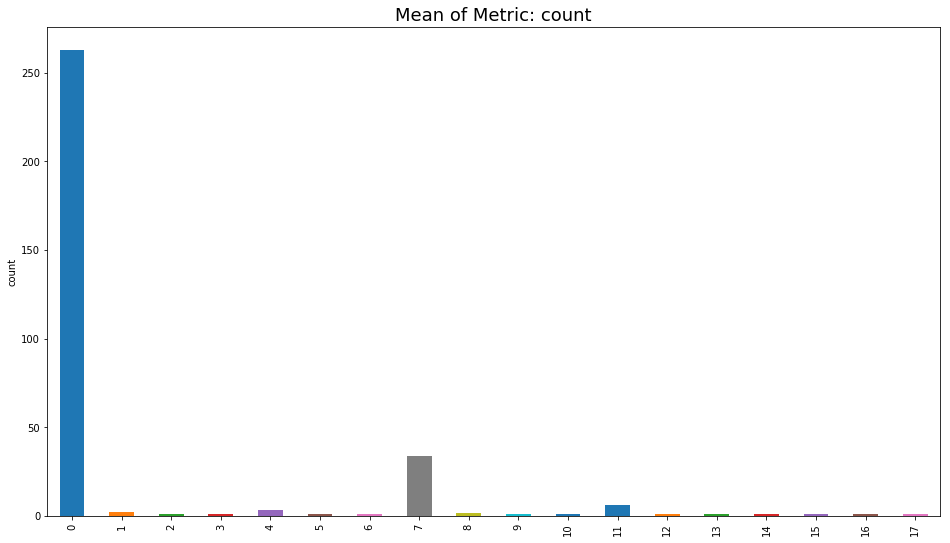

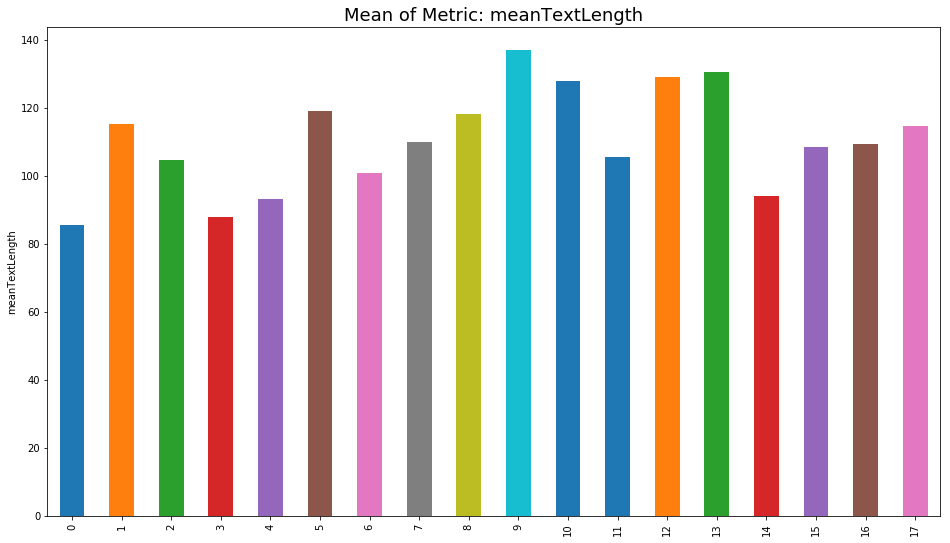

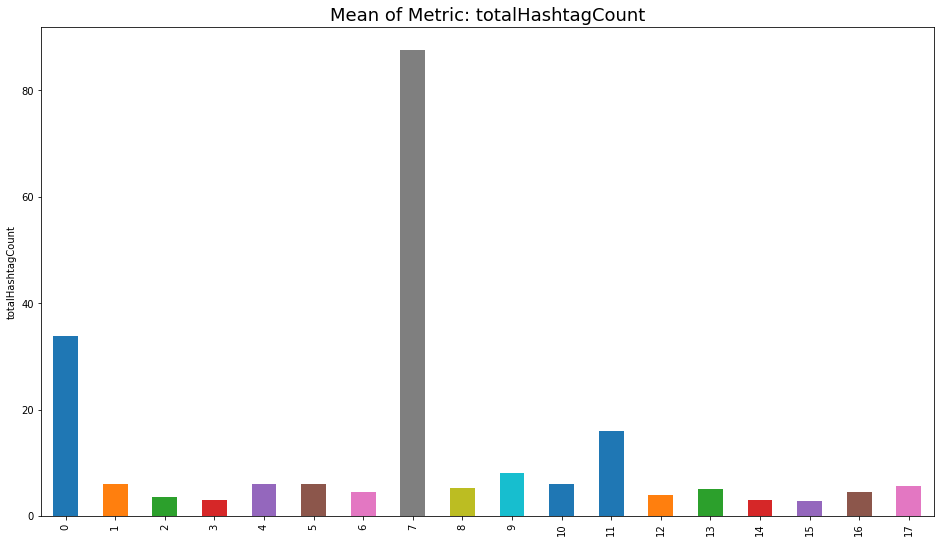

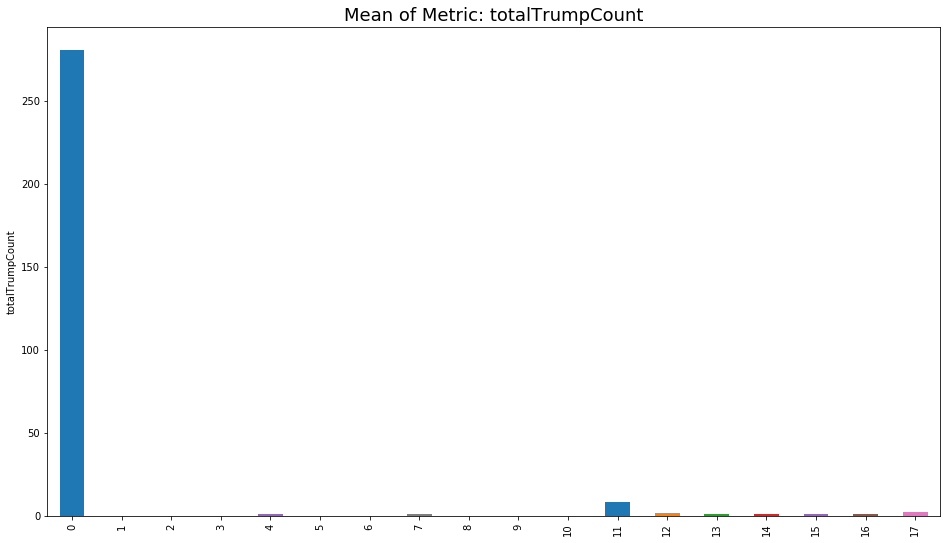

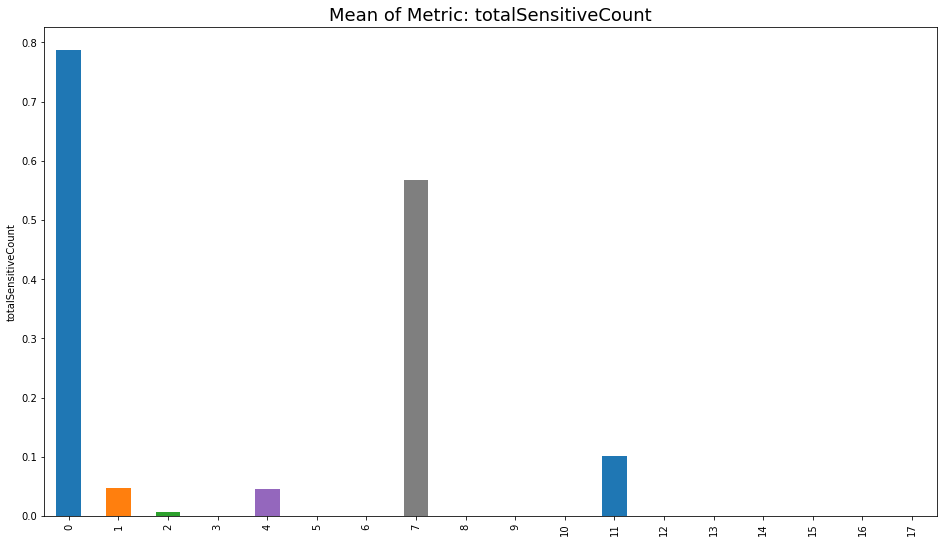

In [14]:
plotMetric(meanMetrics, 'count')
plotMetric(meanMetrics, 'meanTextLength')
plotMetric(meanMetrics, 'totalHashtagCount')
plotMetric(meanMetrics, 'totalTrumpCount')
plotMetric(meanMetrics, 'totalSensitiveCount')

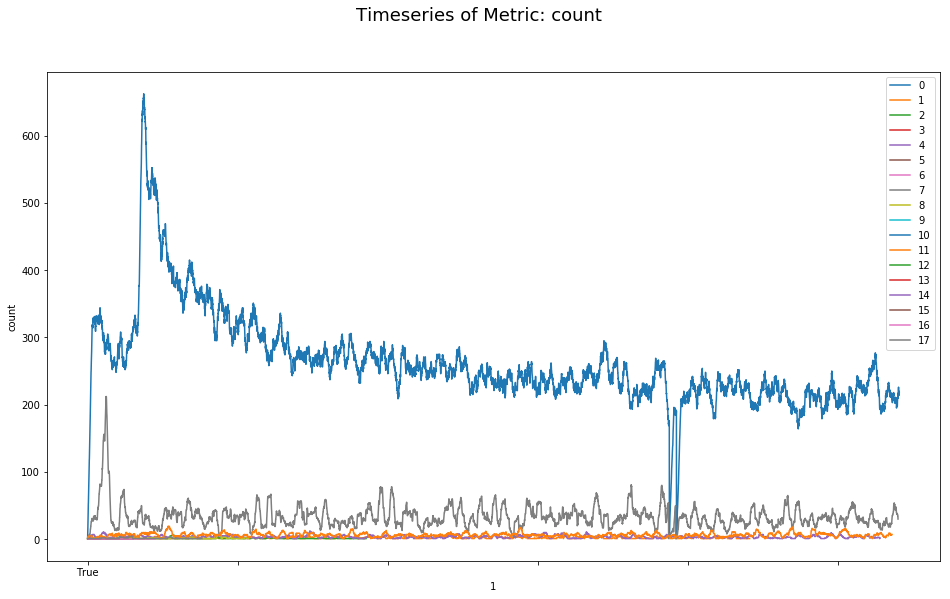

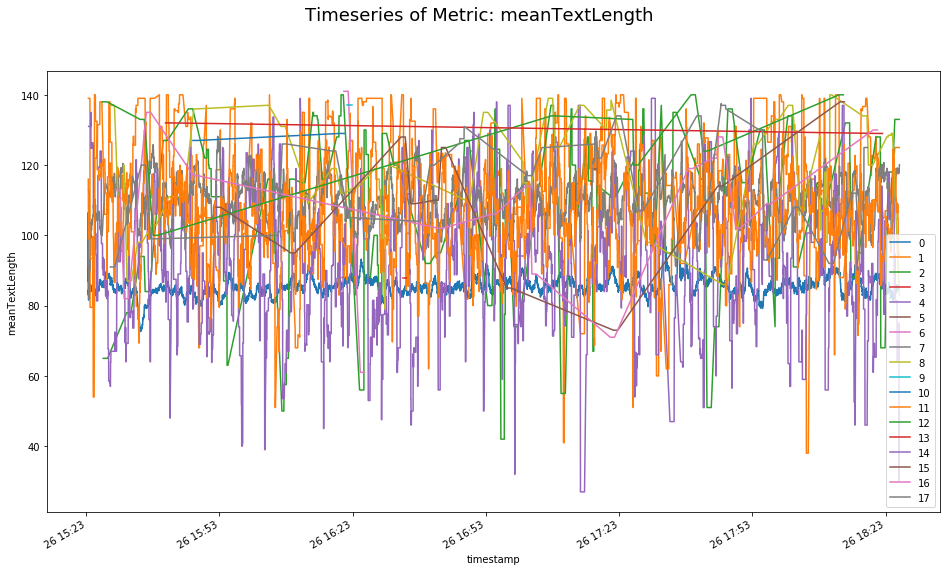

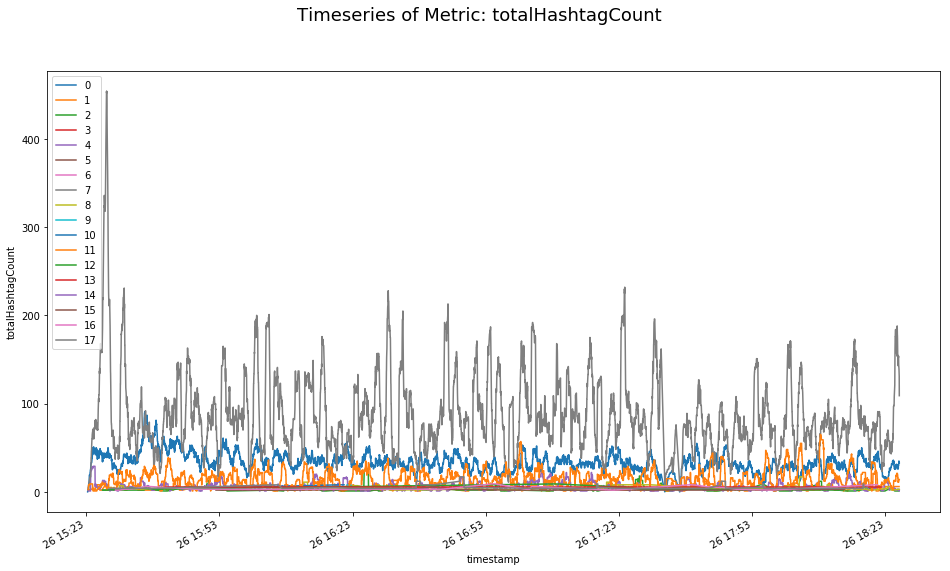

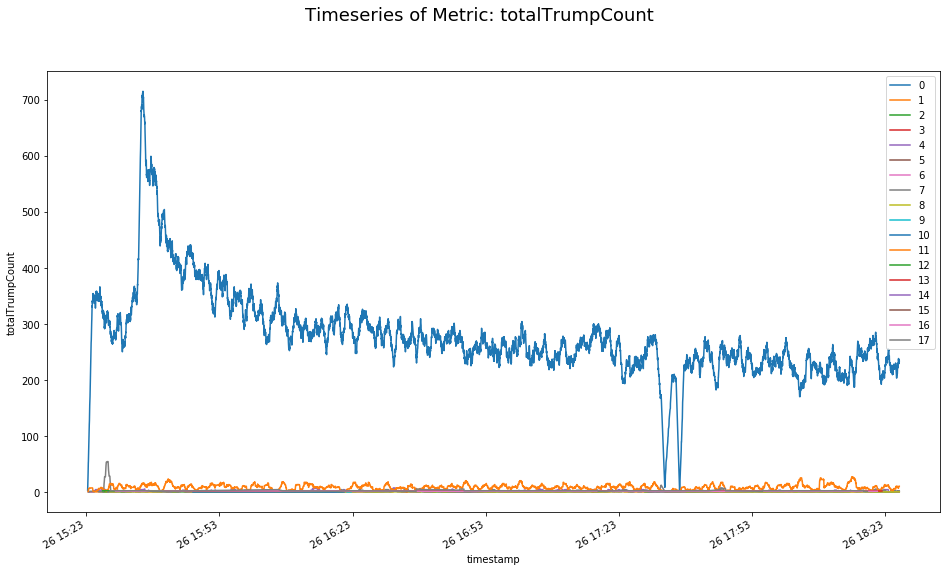

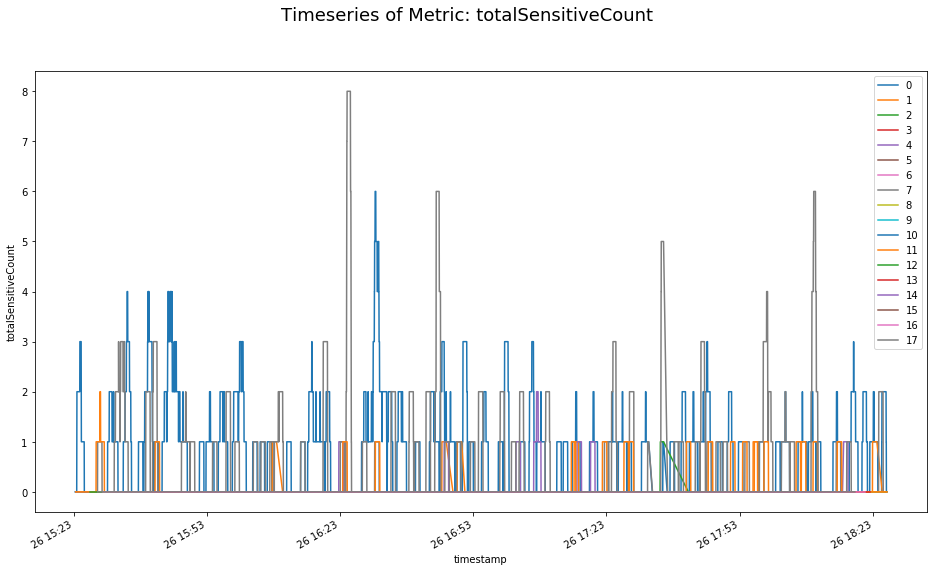

In [15]:
plotMetricTimeseries(comboTimeseriesList, 'count', 1)
plotMetricTimeseries(comboTimeseriesList, 'meanTextLength')
plotMetricTimeseries(comboTimeseriesList, 'totalHashtagCount')
plotMetricTimeseries(comboTimeseriesList, 'totalTrumpCount')
plotMetricTimeseries(comboTimeseriesList, 'totalSensitiveCount')

## Predictions
This approach merges the entries by their time (without a date) and their combo.    
The goal is to achieve a mean-value for each combo and each second of a day.

This mean value functions as prediction for this metric. The Spark application will use and evaluate this prediction.

In [16]:
newComboHistory = comboHistory.copy()
newComboHistory['time'] = comboHistory['timestamp'].apply(lambda x: x.time())

In [17]:
timePredictions = newComboHistory.groupby(['time','isTrumpTweet','isNewsTweet','isFakeNewsTweet','isDemocratsTweet','isPoliticsTweet'])['count', 'meanTextLength',
       'totalHashtagCount', 'totalTrumpCount', 'totalSensitiveCount'].agg(np.mean).reset_index()

#### Save predictions as csv file

In [18]:
timePredictions.to_csv(outputFile,
                       sep=';',
                       quotechar='"',
                       quoting=2,
                       index=False)

#### Read prediction evaluation

In [19]:
predEvaluation = pd.read_csv(evalFile,
                             sep=";", 
                             header = 0)

In [20]:
predEvaluation.columns

Index(['timestamp', 'isTrumpTweet', 'isNewsTweet', 'isFakeNewsTweet',
       'isDemocratsTweet', 'isPoliticsTweet', 'time', 'count',
       'meanTextLength', 'totalHashtagCount', 'totalTrumpCount',
       'totalSensitiveCount', 'hasPrediction', 'errorCount', 'errorCountRel',
       'errorMeanTextLength', 'errorMeanTextLengthRel',
       'errorTotalHashtagCount', 'errorTotalHashtagCountRel',
       'errorTotalTrumpCount', 'errorTotalTrumpCountRel',
       'errorTotalSensitiveCount', 'errorTotalSensitiveCountRel',
       'meanErrorRel'],
      dtype='object')

#### Transformation

In [21]:
# transform timestamp strings to datetime format
predEvaluation['timestamp'] = pd.to_datetime(comboHistory['timestamp']) + timedelta(hours=1)

In [22]:
# group by hashtag combination, calculate mean values of metrics
meanEvals = predEvaluation.groupby(['isTrumpTweet','isNewsTweet','isFakeNewsTweet','isDemocratsTweet','isPoliticsTweet'])['errorCount', 'errorMeanTextLength',
       'errorTotalHashtagCount', 'errorTotalTrumpCount', 'errorTotalSensitiveCount'].agg(np.mean).reset_index()
meanEvals

,isTrumpTweet,isNewsTweet,isFakeNewsTweet,isDemocratsTweet,isPoliticsTweet,errorCount,errorMeanTextLength,errorTotalHashtagCount,errorTotalTrumpCount,errorTotalSensitiveCount
0,False,False,False,False,False,132.547368,88.553599,15.863158,141.852632,0.073684
1,False,False,False,False,True,4.000000,113.311111,12.000000,0.000000,0.000000
2,False,False,False,True,False,1.000000,107.413793,2.241379,0.000000,0.310345
3,False,False,True,False,False,1.471698,58.625786,1.811321,0.000000,0.000000
4,False,True,False,False,False,16.329787,107.564137,33.095745,0.000000,1.223404
5,True,False,False,False,False,2.917647,91.414118,6.917647,2.917647,0.000000


In [23]:
evalList = list()
for i in range(0, len(meanEvals)):
    evalList.append(meanEvals.loc[i,['isTrumpTweet','isNewsTweet','isFakeNewsTweet','isDemocratsTweet','isPoliticsTweet']].to_frame().transpose())

In [24]:
evalTimeseriesList = list()
for i in range(0,len(evalList)):
    evalTimeseriesList.append(evalList[i]
                              .merge(predEvaluation,on=['isTrumpTweet',
                                                        'isNewsTweet',
                                                        'isFakeNewsTweet',
                                                        'isDemocratsTweet',
                                                        'isPoliticsTweet']))

#### Plots

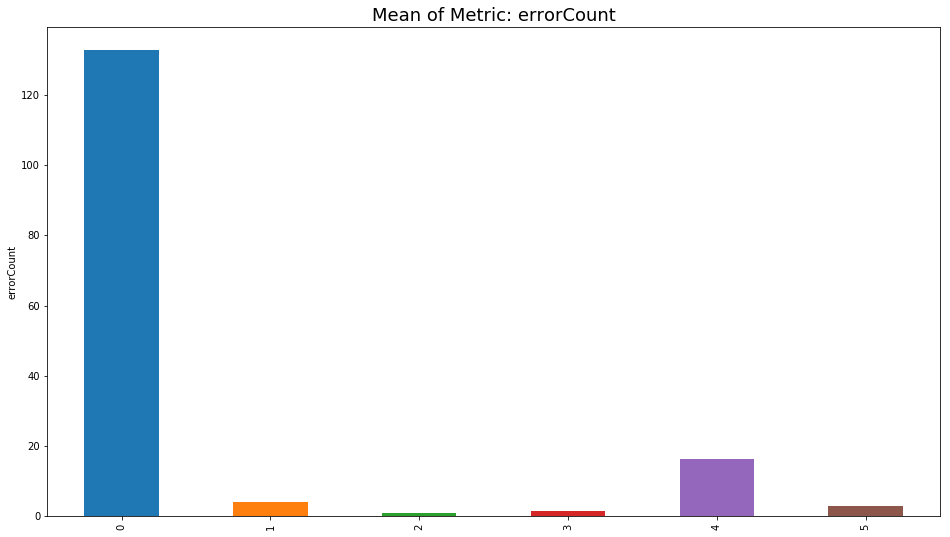

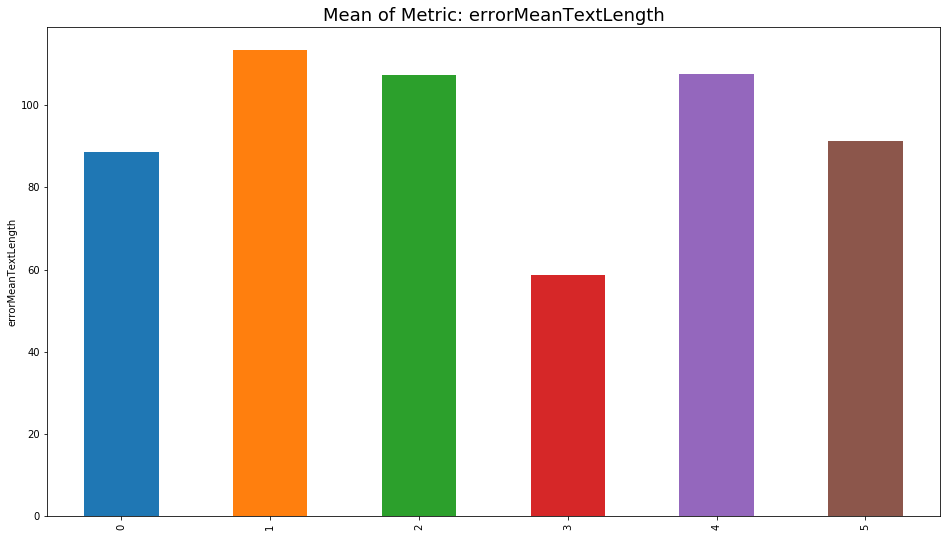

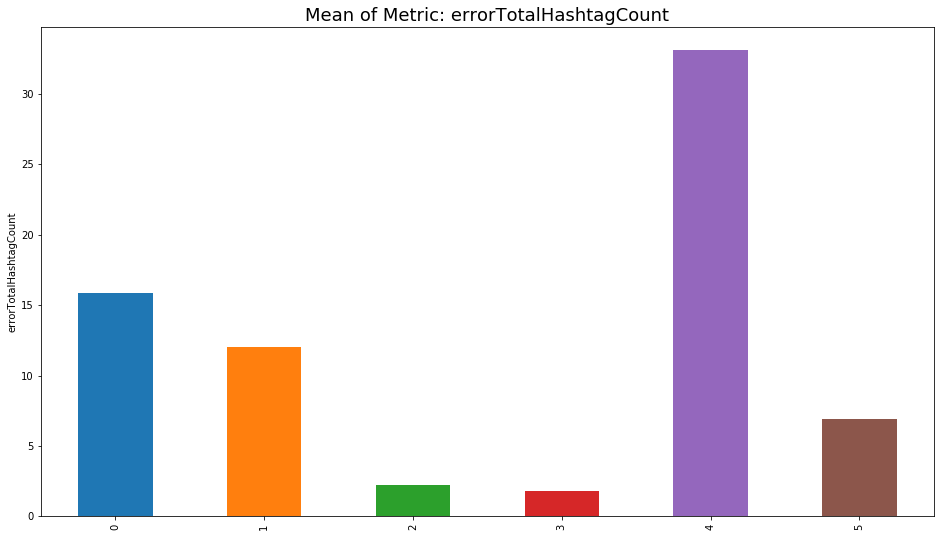

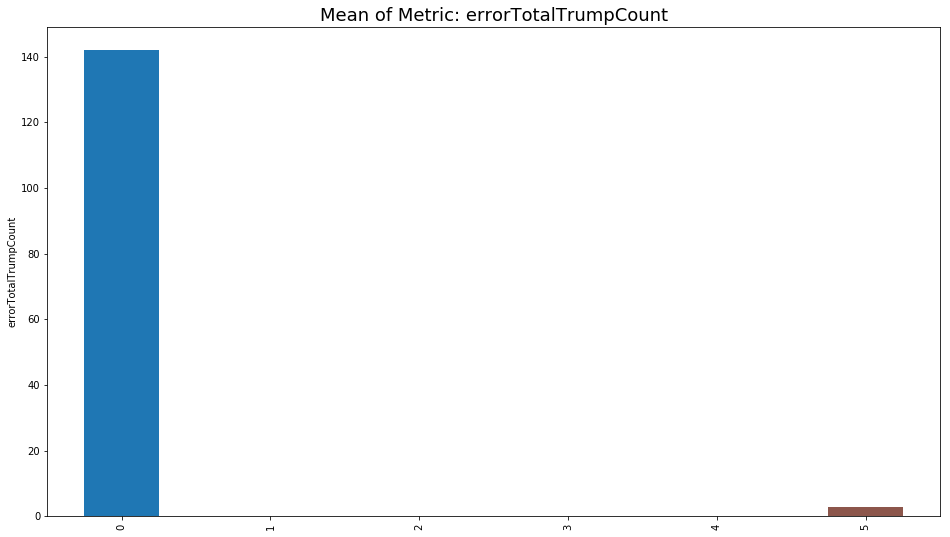

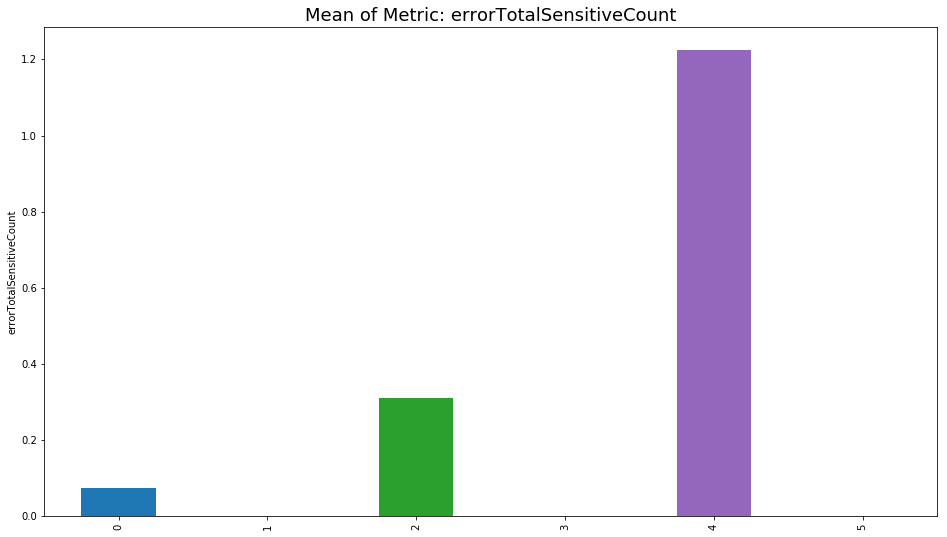

In [25]:
plotMetric(meanEvals, 'errorCount')
plotMetric(meanEvals, 'errorMeanTextLength')
plotMetric(meanEvals, 'errorTotalHashtagCount')
plotMetric(meanEvals, 'errorTotalTrumpCount')
plotMetric(meanEvals, 'errorTotalSensitiveCount')

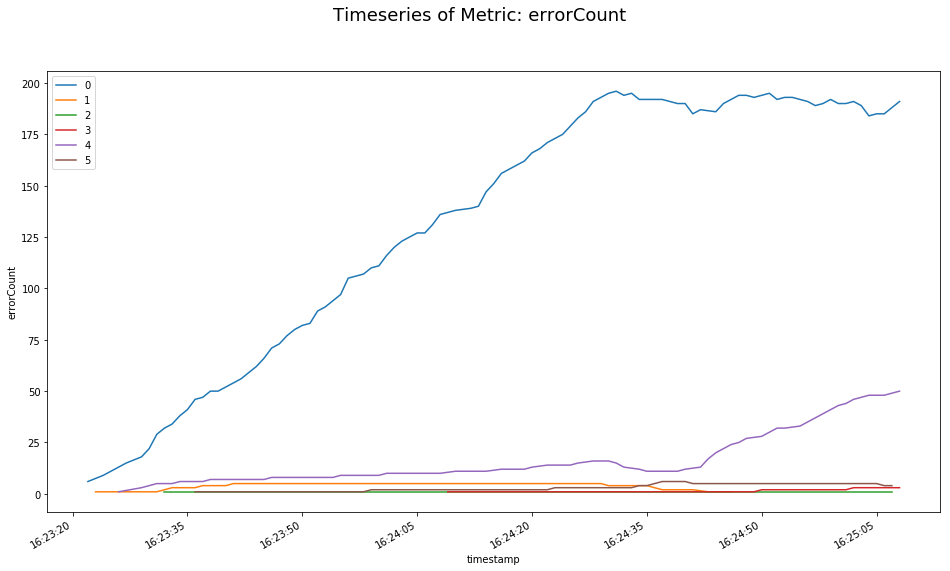

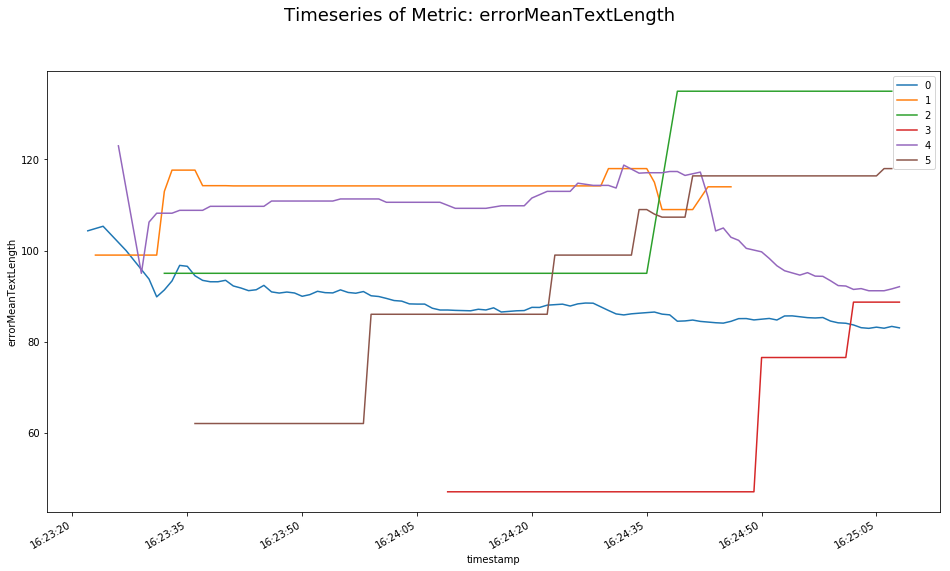

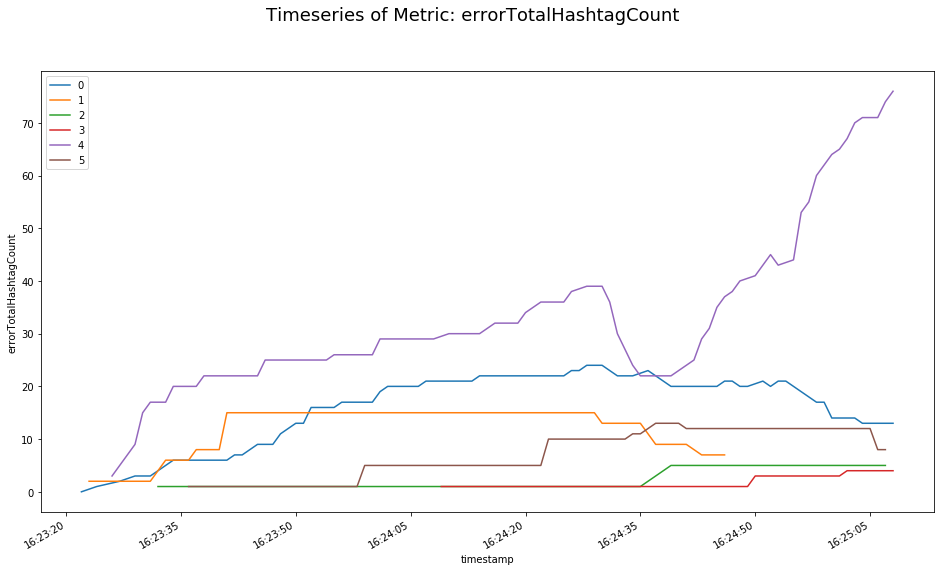

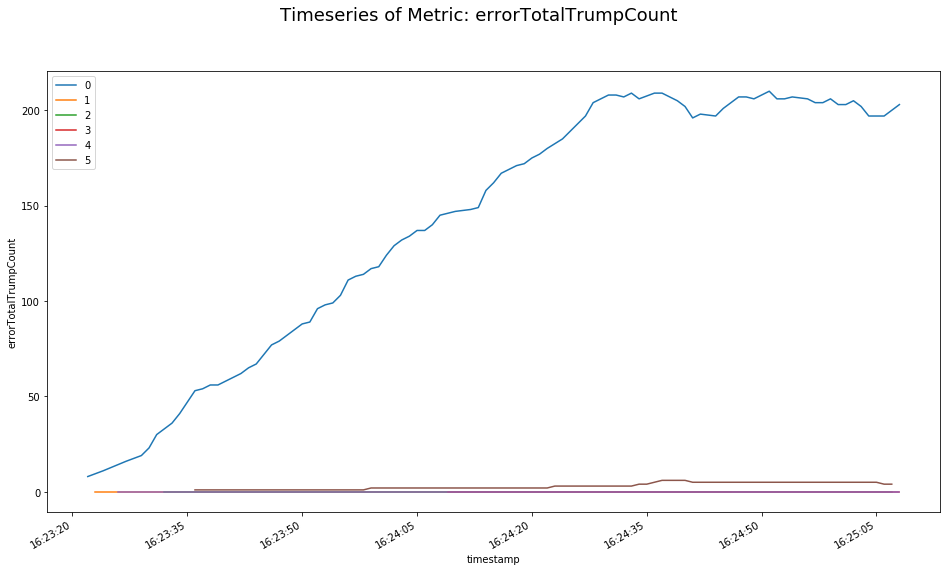

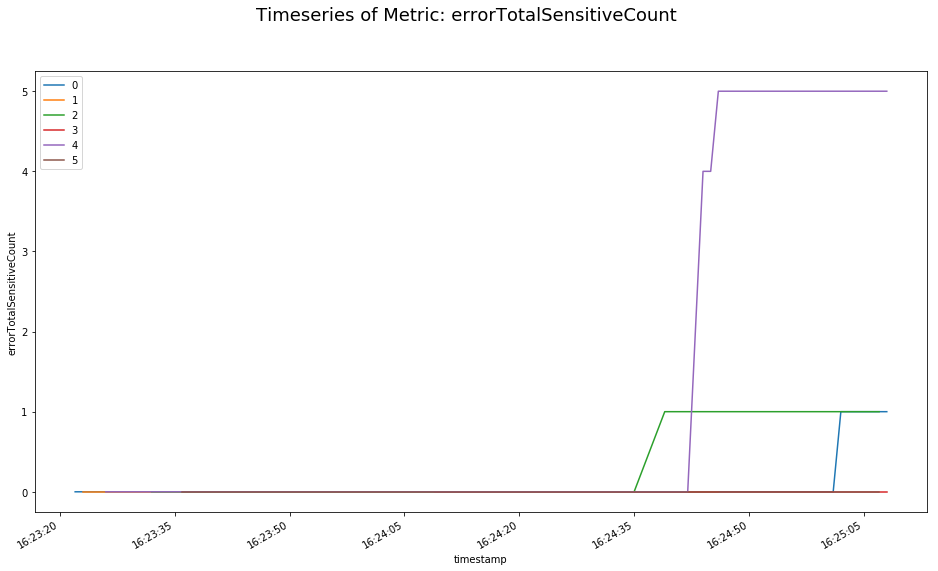

In [26]:
plotMetricTimeseries(evalTimeseriesList, 'errorCount')
plotMetricTimeseries(evalTimeseriesList, 'errorMeanTextLength')
plotMetricTimeseries(evalTimeseriesList, 'errorTotalHashtagCount')
plotMetricTimeseries(evalTimeseriesList, 'errorTotalTrumpCount')
plotMetricTimeseries(evalTimeseriesList, 'errorTotalSensitiveCount')

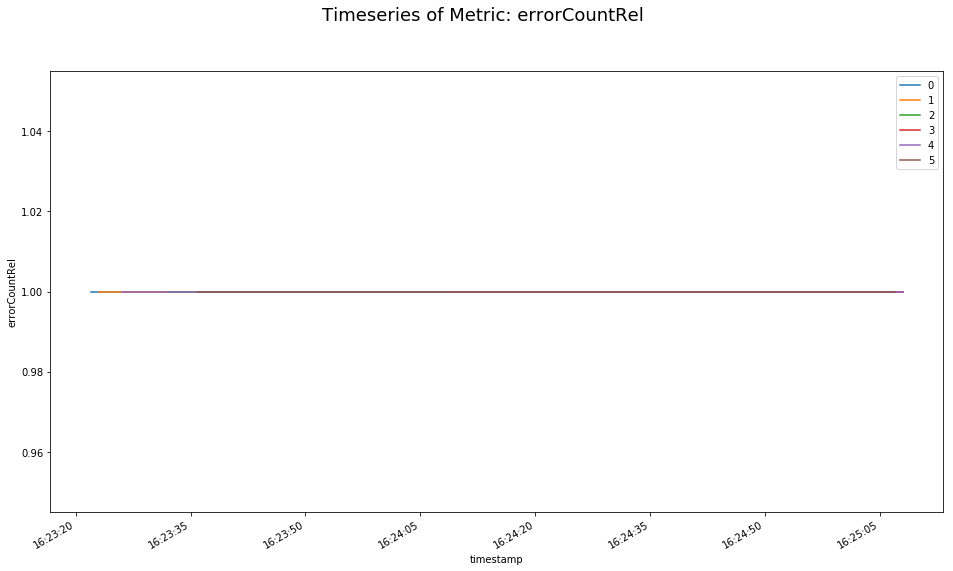

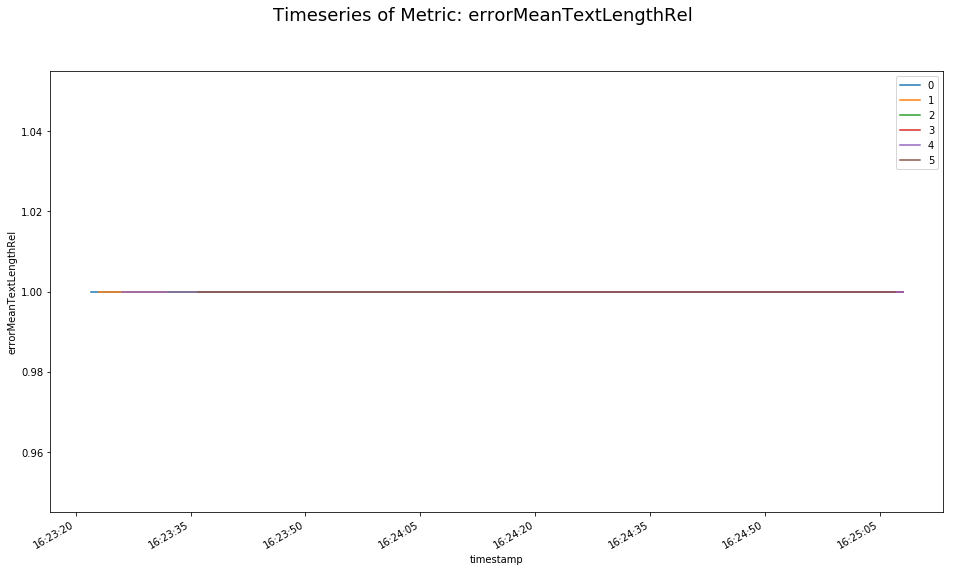

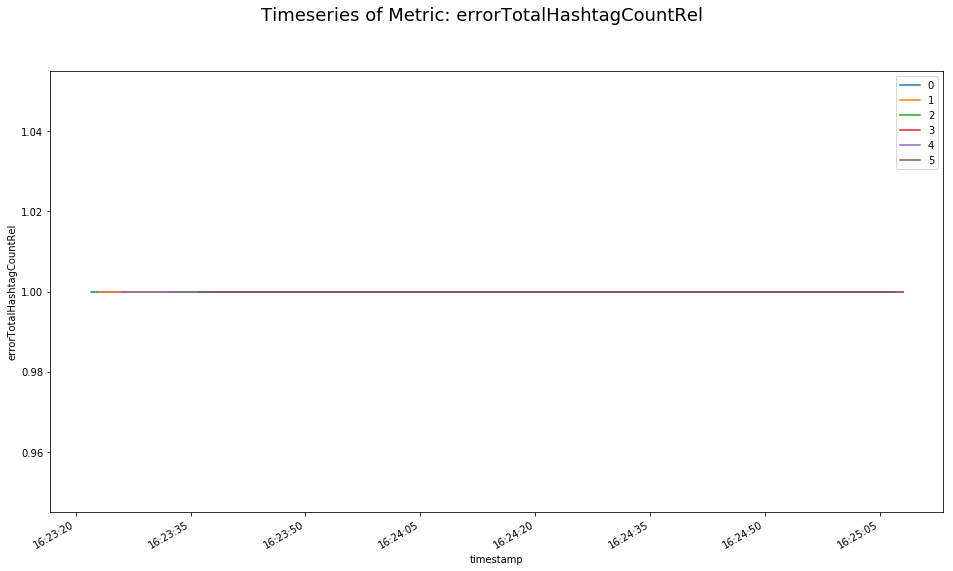

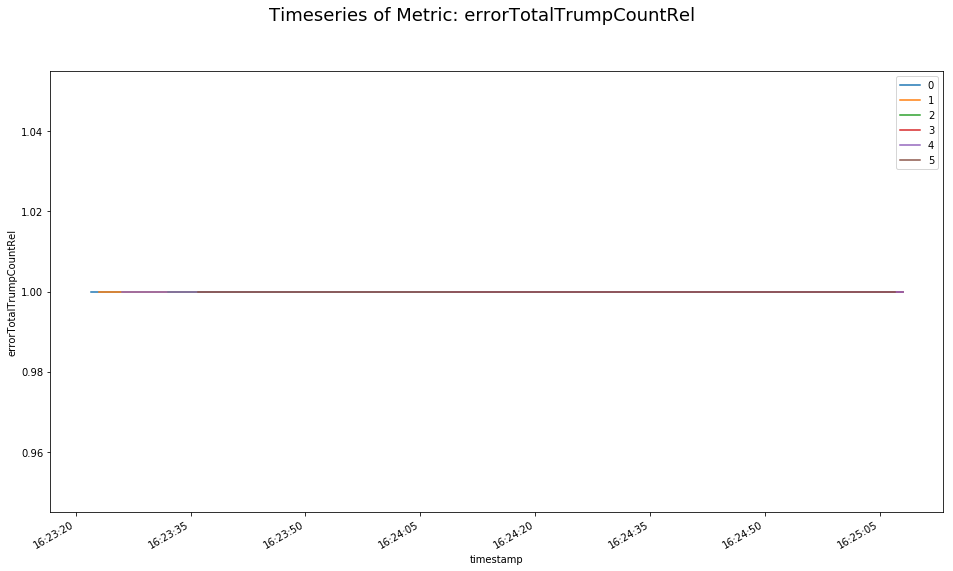

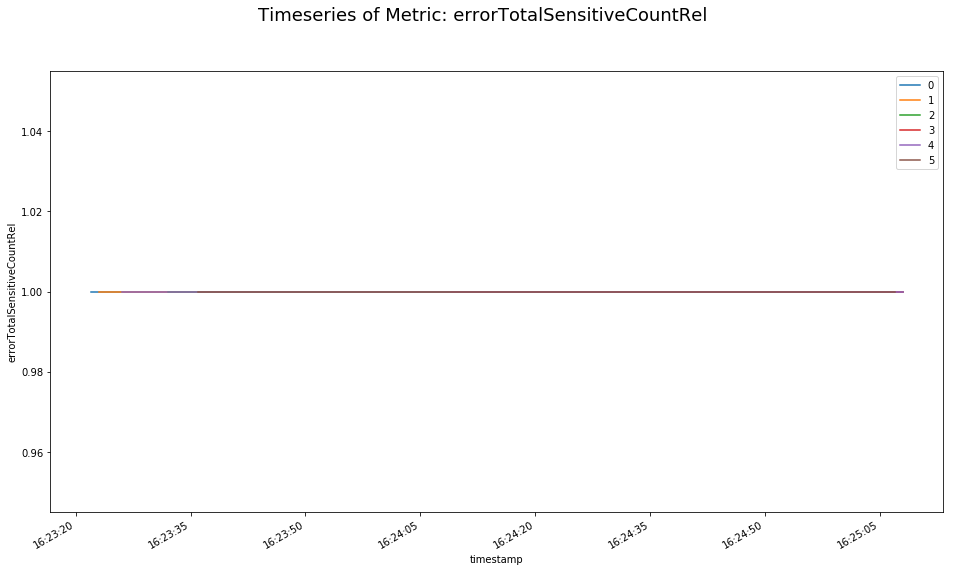

In [27]:
plotMetricTimeseries(evalTimeseriesList, 'errorCountRel')
plotMetricTimeseries(evalTimeseriesList, 'errorMeanTextLengthRel')
plotMetricTimeseries(evalTimeseriesList, 'errorTotalHashtagCountRel')
plotMetricTimeseries(evalTimeseriesList, 'errorTotalTrumpCountRel')
plotMetricTimeseries(evalTimeseriesList, 'errorTotalSensitiveCountRel')